## Sorting Experiment

The Sorting dataset consists of 64 Java sorting programs implementing either a BubbleSort or InsertionSort algorithm. The algorithm serves as class label.

More information on the data set is available at [doi:10.4119/unibi/2900684](http://doi.org/10.4119/unibi/2900684).


In [1]:
# load the data
from tree_utils import dataset_from_json
dataset_name = 'sorting'
trees, filenames = dataset_from_json(dataset_name)

# label the data according to filename
X = []
Y = []
for i in range(len(trees)):
    if(filenames[i].startswith('Bubble')):
        Y.append(0)
    elif(filenames[i].startswith('Insertion')):
        Y.append(1)
    else:
        continue
    X.append(trees[i])

del trees
del filenames

import numpy as np
Y = np.array(Y)

In [2]:
# compute all pairwise tree edit distances
import multiprocess as mp

D = mp.pairwise_distances_symmetric(X)

In [3]:
# show the distances
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
cax = axs.matshow(D)
fig.colorbar(cax)
plt.show()

<Figure size 640x480 with 2 Axes>

In [4]:
# set up possible C values for the SVM
Cs     = [0.1, 1., 10., 100.]

# pre-compute all kernel variations for all hyperparameter
# values
kernel_types = ['linear', 'RBF', 'ST', 'SST', 'PT']
Ks = [[], [], [], [], []]

# pre-compute linear kernel matrix via double centering
import scipy.linalg
d_row_mean = np.expand_dims(np.mean(D, axis=0), 1)
K_linear = 0.5 * (-D + d_row_mean + d_row_mean.T - np.mean(D))
Lambda, V = scipy.linalg.eig(K_linear)
Lambda[Lambda < 0] = 0
K_linear = np.real(np.dot(V, np.dot(np.diag(Lambda), V.T)))
Ks[0] = [K_linear]
del K_linear
del Lambda
del V

# pre-compute RBF kernel matrix
sigmas = np.array([0.1, 0.5, 1., 2.]) * np.mean(D)
for s in range(len(sigmas)):
    K = np.exp(-0.5 * np.square(D) / (sigmas[s] ** 2))
    K = 0.5 * (K + K.T)
    Lambda, V = scipy.linalg.eig(K)
    Lambda[Lambda < 0] = 0
    Ks[1].append(np.real(np.dot(V, np.dot(np.diag(Lambda), V.T))))
del K
del Lambda
del V

# prepare trees in PTK format
import ptk_utils
X_ptk = []
for x_nodes, x_adj in X:
    X_ptk.append(ptk_utils.to_ptk_tree(x_nodes, x_adj))
    
# pre-compute PTK kernel matrices
lambdas = [0.001, 0.01, 0.1]

for kernel_type in range(2, len(kernel_types)):
    for l in range(len(lambdas)):
        Ks[kernel_type].append(ptk_utils.pairwise_kernel_symmetric(X_ptk, kernel_types[kernel_type], lambdas[l]))

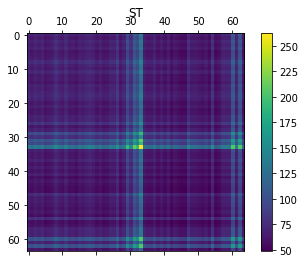

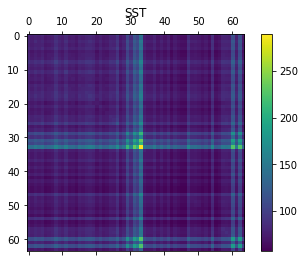

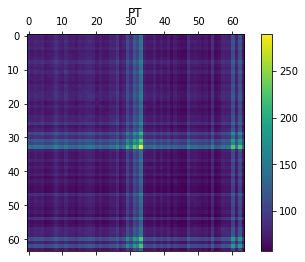

In [5]:
# show kernels
for kernel_type in range(2, len(kernel_types)):
    fig, axs = plt.subplots()
    cax = axs.matshow(Ks[kernel_type][-1])
    fig.colorbar(cax)
    plt.title(kernel_types[kernel_type])
    plt.show()

In [6]:
# set up out-of-sample methods for each kernel type
def oos_linear(x_nodes, x_adj, train_index):
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    # compute the edit distances to all training data points
    d = mp.pairwise_distances([(x_nodes, x_adj)], X_train)
    # compute the kernel values
    return 0.5 * (-d + np.mean(d) + np.mean(D[:, train_index], axis=0) - np.mean(D))
    
def oos_rbf(x_nodes, x_adj, train_index, sigma):
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    # compute the edit distances to all training data points
    d = mp.pairwise_distances([(x_nodes, x_adj)], X_train)
    # compute the kernel values
    return np.exp(-0.5 * np.square(d) / (sigma ** 2))
    
def oos_ptk(x_nodes, x_adj, train_index, kernel_type, lambda_):
    x = ptk_utils.to_ptk_tree(x_nodes, x_adj)
    X_train = []
    for i in train_index:
        X_train.append(ptk_utils.to_ptk_tree(X[i][0], X[i][1]))
    # compute the edit distances to all training data points
    return ptk_utils.pairwise_kernel([x], X_train, kernel_types[kernel_type], lambda_)

In [7]:
# gather the alphabet of out data set for recursive neural net computations
neural_net_types = ['recursive', 'tree echo state']

alphabet = set()
for i in range(len(X)):
    alphabet.update(X[i][0])
alphabet = list(alphabet)
alphabet.sort()
dim = 10
unique_labels = list(np.unique(Y))

# set up training functions for both neural net types
def recursive_train(X_train, Y_train):
    rec_net = RecursiveNetClassifier(dim, unique_labels, alphabet)
    learning_curve = rec_net.fit(X_train, Y_train, print_step = 100)
    print('completed training after %d steps' % len(learning_curve))
    return rec_net

dims = [10, 50, 100]
radii = [0.7, 0.9, 1., 1.5, 2]

def tree_echo_state_train(X_train, Y_train):
    # perform hyper-parameter optimization first
    dim, radius, _ = grid_search_cv_echo_state(X_train, Y_train, alphabet, dims, radii)
    print('finished hyper parameter optimization')
    # train tree echo state network
    rec_net = TreeEchoStateNetClassifier(dim, alphabet, radius=radius)
    rec_net.fit(X_train, Y_train)
    return rec_net

neural_net_train_funs = [recursive_train, tree_echo_state_train]

In [8]:
# set up crossvalidation folds
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from recursive_net import RecursiveNetClassifier
from tree_echo_state import TreeEchoStateNetClassifier
from hyperopt import grid_search_cv_svm
from hyperopt import grid_search_cv_echo_state
from adversarial_edits import construct_random_adversarials
from adversarial_edits import construct_adversarials

n_split_outer = 8
n_split_inner = 8

outer_cv = StratifiedKFold(n_splits=n_split_outer, shuffle=True)

# set up result matrices
conditions = ['original', 'random', 'adversarial']

accs = np.zeros((n_split_outer, len(kernel_types) + len(neural_net_types), len(conditions)))
d_adversarial = np.zeros((n_split_outer, len(kernel_types) + len(neural_net_types), len(conditions) - 1))
Zs = [[[None] * len(X)] * (len(kernel_types) + len(neural_net_types))] * (len(conditions) - 1)

# iterate over the folds
f = -1
for train_index, test_index in outer_cv.split(X, Y):
    f += 1
    print('--- fold %d of %d ---' % (f+1, n_split_outer))
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    X_test = []
    for i in test_index:
        X_test.append(X[i])

    # iterate over our kernels
    for kernel_type in range(len(kernel_types)):
        print('%s kernel' % kernel_types[kernel_type])
        # perform a nested crossvalidation to optimize hyper-parameters
        C, k, _ = grid_search_cv_svm(Y, Cs, Ks[kernel_type], n_split_inner, train_index)
        print('finished hyper parameter optimization')
        # select the best kernel matrix
        K = Ks[kernel_type][k]
        K_train = K[train_index, :][:, train_index]
        K_test  = K[test_index, :][:, train_index]
        # train an SVM with the optimal hyperparameters
        svm = SVC(kernel='precomputed', decision_function_shape='ovo', C = C)
        svm.fit(K_train, Y[train_index])
        # evaluate the test accuracy
        Y_pred  = svm.predict(K_test)
        correct = Y[test_index] == Y_pred
        accs[f, kernel_type, 0] = accuracy_score(Y[test_index], Y_pred)
        print('accuracy: %g' % accs[f, kernel_type, 0])
        # then, start the adversarial construction on the test data
        # set up the out of sample function for the current kernel
        if(kernel_type == 0):
            oos = oos_linear
        elif(kernel_type == 1):
            oos = lambda x_nodes, x_adj, train_index: oos_rbf(x_nodes, x_adj, train_index, sigmas[k])
        else:
            oos = lambda x_nodes, x_adj, train_index: oos_ptk(x_nodes, x_adj, train_index, kernel_type, lambdas[k])
        # set up the predictive function for the current kernel
        def predict(x_nodes, x_adj):
            # compute the kernel values of the new point to the trainign data
            k = oos(x_nodes, x_adj, train_index)
            # and then predict with the SVM
            return svm.predict(k)
        # construct random adversarials
        Z, labels, ds = construct_random_adversarials(X_test, Y[test_index], Y_pred, predict, alphabet, max_d = 100)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, kernel_type, 1] = np.mean(ds[correct] >= 1.)
        print('random adversarial accuracy: %g' % accs[f, kernel_type, 1])
        # the average relative distance to an adversarial example
        d_adversarial[f, kernel_type, 0] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[0][kernel_type][test_index[i]] = Z[i]
        # construct adversarials
        Z, labels, ds = construct_adversarials(X_test, D[test_index, :][:, test_index], Y[test_index], Y_pred, predict)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, kernel_type, 2] = np.mean(ds[correct] >= 1.)
        print('adversarial accuracy: %g' % accs[f, kernel_type, 2])
        # the average relative distance to an adversarial example
        d_adversarial[f, kernel_type, 1] = np.mean(ds[np.logical_not(np.isinf(ds))])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[1][kernel_type][test_index[i]] = Z[i]
    # also train the neural nets on this data
    for net_type in range(len(neural_net_types)):
        t = len(kernel_types) + net_type
        print('%s network' % neural_net_types[net_type])
        rec_net = neural_net_train_funs[net_type](X_train, Y[train_index])
        # check the accuracy
        Y_pred = np.array(rec_net.predict(X_test))
        correct = Y[test_index] == Y_pred
        accs[f, t, 0] = accuracy_score(Y[test_index], Y_pred)
        print('accuracy: %g' % accs[f, t, 0])
        # set up the predictive function
        def predict(x_nodes, x_adj):
            return rec_net.predict([(x_nodes, x_adj)])[0]
        # construct random adversarials
        Z, labels, ds = construct_random_adversarials(X_test, Y[test_index], Y_pred, predict, alphabet, max_d = 100)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, t, 1] = np.mean(ds[correct] >= 1.)
        print('random adversarial accuracy: %g' % accs[f, t, 1])
        # the average relative distance to an adversarial example
        d_adversarial[f, t, 0] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[0][t][test_index[i]] = Z[i]
        # construct adversarials
        Z, labels, ds = construct_adversarials(X_test, D[test_index, :][:, test_index], Y[test_index], Y_pred, predict)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, t, 2] = np.mean(ds[correct] >= 1.)
        print('adversarial accuracy: %g' % accs[f, t, 2])
        # the average relative distnace to an adversarial example
        d_adversarial[f, t, 1] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[1][t][test_index[i]] = Z[i]

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


--- fold 1 of 8 ---
linear kernel
finished hyper parameter optimization
accuracy: 0.888889
random adversarial accuracy: 1


/usr/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


adversarial accuracy: 0.375
RBF kernel
finished hyper parameter optimization
accuracy: 0.888889
random adversarial accuracy: 0.625
adversarial accuracy: 0.375
ST kernel
finished hyper parameter optimization
accuracy: 0.888889
random adversarial accuracy: 0.375
adversarial accuracy: 0.25
SST kernel
finished hyper parameter optimization
accuracy: 0.777778
random adversarial accuracy: 0.571429
adversarial accuracy: 0.428571
PT kernel
finished hyper parameter optimization
accuracy: 0.666667
random adversarial accuracy: 0.5
adversarial accuracy: 0.333333
recursive network
lowest loss after 100 steps: 0.510949
lowest loss after 200 steps: 0.510949
lowest loss after 300 steps: 0.510949
lowest loss after 400 steps: 0.510949
lowest loss after 500 steps: 0.165259
lowest loss after 600 steps: 0.055916
lowest loss after 700 steps: 0.0414111
lowest loss after 800 steps: 0.0389982
lowest loss after 900 steps: 0.0204006
lowest loss after 1000 steps: 0.0204006
lowest loss after 1100 steps: 0.018536
lo

lowest loss after 100 steps: 0.632008
lowest loss after 200 steps: 0.632008
lowest loss after 300 steps: 0.613231
lowest loss after 400 steps: 0.45491
lowest loss after 500 steps: 0.0482822
lowest loss after 600 steps: 0.0301922
lowest loss after 700 steps: 0.020034
lowest loss after 800 steps: 0.0139551
lowest loss after 900 steps: 0.0114175
lowest loss after 1000 steps: 0.0114175
completed training after 1018 steps
accuracy: 0.857143
random adversarial accuracy: 0.666667
adversarial accuracy: 1
tree echo state network
finished hyper parameter optimization
accuracy: 0.857143
random adversarial accuracy: 0.166667
adversarial accuracy: 0.666667
--- fold 8 of 8 ---
linear kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 1
adversarial accuracy: 0.428571
RBF kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.857143
adversarial accuracy: 0.428571
ST kernel
finished hyper parameter optimization
accuracy: 0.571429
rando

In [10]:
for kernel_type in range(len(kernel_types)):
    print('%s kernel' % kernel_types[kernel_type])
    print('on average, we needed the following distance to flip the label: %g' % np.mean(d_adversarial[:, kernel_type, -1]))
    print('we could generate adversarial examples for %g%% of the data' % (100. - 100.* np.mean(accs[:, kernel_type, -1])))
for net_type in range(len(neural_net_types)):
    t = len(kernel_types) + net_type
    print('%s network' % neural_net_types[net_type])
    print('on average, we needed the following distance to flip the label: %g' % np.mean(d_adversarial[:, t, -1]))
    print('we could generate adversarial examples for %g%% of the data' % (100. - 100.* np.mean(accs[:, t, -1])))

linear kernel
on average, we needed the following distance to flip the label: 1.54941
we could generate adversarial examples for 44.4444% of the data
RBF kernel
on average, we needed the following distance to flip the label: 1.63608
we could generate adversarial examples for 42.4851% of the data
ST kernel
on average, we needed the following distance to flip the label: 3.01042
we could generate adversarial examples for 60.6746% of the data
SST kernel
on average, we needed the following distance to flip the label: 1.67112
we could generate adversarial examples for 49.2262% of the data
PT kernel
on average, we needed the following distance to flip the label: 1.69091
we could generate adversarial examples for 50.4167% of the data
recursive network
on average, we needed the following distance to flip the label: 1.87055
we could generate adversarial examples for 26.1905% of the data
tree echo state network
on average, we needed the following distance to flip the label: 2.39743
we could gener

In [12]:
# print the results to a CSV table
np.savetxt('results/%s_accs.csv' % dataset_name, accs[:, :, 0], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_accs_random_adversarial.csv' % dataset_name, accs[:, :, 1], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_d_random_adversarial.csv' % dataset_name, d_adversarial[:, :, 0], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_accs_adversarial.csv' % dataset_name, accs[:, :, 2], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_d_adversarial.csv' % dataset_name, d_adversarial[:, :, 1], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')

In [13]:
# print the adversarial examples to a pickle file
dataset_name = 'sorting'
import pickle
with open('results/%s_adversarials.pickle' % dataset_name, 'wb') as pickle_file:
    pickle.dump(Zs, pickle_file)